In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

from mpitree.tree import DecisionTreeClassifier

In [2]:
np.random.seed(42)

In [3]:
iris = load_iris()
X, y = iris.data[:, :2], iris.target

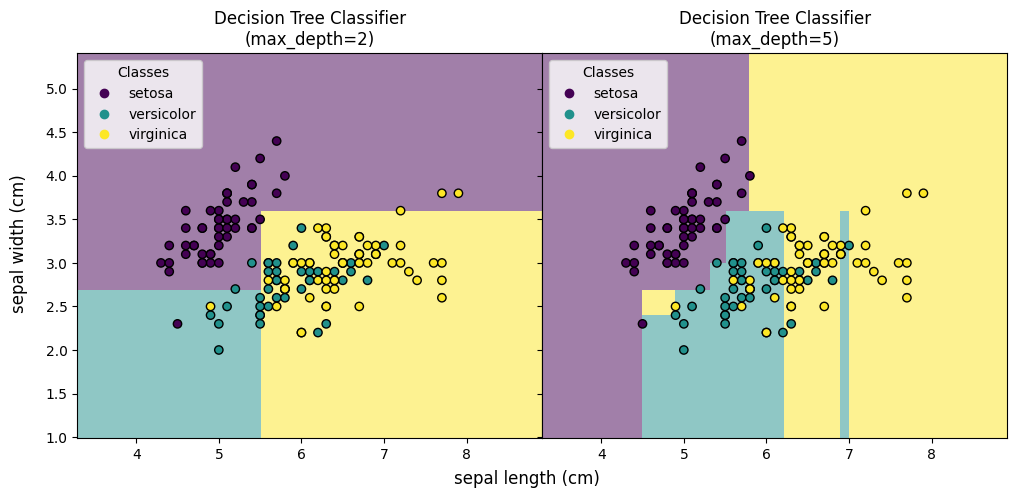

In [4]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, axs = plt.subplots(
    ncols=2,
    sharex="col",
    sharey="row",
    figsize=(12, 5),
    gridspec_kw={"wspace": 0, "hspace": 0},
)

for ax, depth in zip(axs, (2, 5)):
    clf = DecisionTreeClassifier(max_depth=depth).fit(X, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        grid_resolution=200,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X[:, 0], X[:, 1], c=iris.target, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="upper left",
        title="Classes",
    )
    _ = disp.ax_.set_title(f"Decision Tree Classifier\n(max_depth={depth})")

fig.supxlabel("sepal length (cm)")
fig.supylabel("sepal width (cm)", x=0.069)

plt.show()

In [5]:
clf = DecisionTreeClassifier().fit(X, y)
print(clf)

┌── feature_0
│  ├── feature_1 [> 5.5]
│  │  ├── feature_0 [> 3.6]
│  │  │  └── class: 2 [> 5.8]
│  │  │  └── class: 0 [<= 5.8]
│  │  ├── feature_0 [<= 3.6]
│  │  │  ├── feature_0 [> 6.2]
│  │  │  │  ├── feature_0 [<= 7.0]
│  │  │  │  │  ├── feature_1 [<= 6.9]
│  │  │  │  │  │  ├── feature_0 [> 2.3]
│  │  │  │  │  │  │  ├── feature_1 [> 6.5]
│  │  │  │  │  │  │  │  ├── feature_0 [<= 3.1]
│  │  │  │  │  │  │  │  │  ├── feature_1 [> 6.6]
│  │  │  │  │  │  │  │  │  │  ├── feature_1 [> 2.5]
│  │  │  │  │  │  │  │  │  │  │  ├── feature_0 [> 2.8]
│  │  │  │  │  │  │  │  │  │  │  │  ├── feature_0 [> 6.7]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 2 [> 6.8]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 2 [<= 6.8]
│  │  │  │  │  │  │  │  │  │  │  │  ├── feature_1 [<= 6.7]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 1 [> 3.0]
│  │  │  │  │  │  │  │  │  │  │  │  │  └── class: 1 [<= 3.0]
│  │  │  │  │  │  │  │  │  │  │  └── class: 1 [<= 2.8]
│  │  │  │  │  │  │  │  │  │  └── class

In [6]:
# from itertools import product

# n_classes = np.unique(y)
# colors = "w", "whitesmoke", "darkgray"
# markers = list("s^o")

# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# n_rows, n_cols = 2, 2
# fig, axs = plt.subplots(
#     n_rows,
#     n_cols,
#     sharex="col",
#     sharey="row",
#     figsize=(10, 7.5),
#     gridspec_kw={"wspace": 0, "hspace": 0},
# )

# for (i, j), clf in zip(product(*map(range, [n_rows, n_cols])), estimators):
#     z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
#     axs[i, j].contourf(xx, yy, z, alpha=0.4)

#     for t, c, marker in zip(n_classes, colors, markers):
#         axs[i, j].scatter(
#             X[y == t, 0],
#             X[y == t, 1],
#             c=c,
#             s=30,
#             linewidth=1.2,
#             marker=marker,
#             label=t,
#         )

# axs[0, 0].legend(title="Class", loc="upper left", shadow=True)

# fig.suptitle("Decision Tree Classifiers varying $max\_depth$ values")
# fig.supxlabel("sepal length (cm)")
# fig.supylabel("sepal width (cm)")

# plt.show()

In [7]:
# n_classes = np.unique(y)
# colors = "w", "darkgray"
# markers = list("s^")

# plt.figure()

# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
# plt.contourf(xx, yy, Z, alpha=0.4, cmap="Greys")

# for t, c, marker in zip(n_classes, colors, markers):
#     plt.scatter(
#         X[y == t, 0],
#         X[y == t, 1],
#         c=c,
#         s=30,
#         linewidth=1.2,
#         marker=marker,
#         label=t,
#     )

# plt.legend(title="Class", loc="upper left", shadow=True)
# plt.show()